# *ETF_Portfolio_Risk_Analysis*

In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter
import matplotlib.ticker as mtick
from scipy.interpolate import interp1d

# Load Data

In this introductory section, I retrieved the data from the VettaFi ETF Screener.

In [16]:
df = pd.read_csv("C:/Users/Francesco Beretta/Downloads/etfdb_screener.csv", skiprows=1)
df.head()

,Symbol,Name,Asset Class,Assets,Avg. Daily Volume,Price,Inverse,Leveraged,Smart Beta,Currency Hedged,...,Volatility,ETF Database Pro,Dividend.1,Concentration,ESG Score,ESG Score Peer Percentile (%),ESG Score Global Percentile (%),Carbon Intensity (Tons of CO2e / $M Sales),ESG Exclusion Criteria (%),Sustainable Impact Solutions (%)
0,SPY,SPDR S&P 500 ETF Trust,Equity,"$681,075,000,000","73,599,195",$685.24,False,False,False,False,...,B+,A-,B+,A-,6.27,32.75%,42.23%,92.42,12.26%,9.09%
1,IVV,iShares Core S&P 500 ETF,Equity,"$704,203,000,000","6,223,786",$688.60,False,False,False,False,...,B+,A,A-,A-,6.27,34.09%,42.39%,92.27,12.21%,9.06%
2,VTI,Vanguard Total Stock Market ETF,Equity,"$551,458,000,000","4,080,108",$337.43,False,False,False,False,...,B+,A,A-,A,6.20,21.11%,39.38%,95.8,11.38%,8.62%
3,VOO,Vanguard S&P 500 ETF,Equity,"$777,489,000,000","7,405,939",$630.00,False,False,False,False,...,B+,A,A-,A-,6.27,32.22%,42.18%,92.59,12.28%,9.11%
4,QQQ,Invesco QQQ Trust Series I,Equity,"$394,428,000,000","51,239,984",$628.09,False,False,False,False,...,C+,B,B-,B-,6.27,35.41%,42.56%,54.59,9.26%,11.13%


I decided to keep only the rows containing the Assets value (the amount of money managed by each ETF), as this metric is the most meaningful for the analysis.

In [23]:
df = df[df['Assets'].notna()]
df.isnull().sum()

Symbol                                           0
Name                                             0
Asset Class                                      0
Assets                                           0
Avg. Daily Volume                              263
                                              ... 
ESG Score Peer Percentile (%)                 1266
ESG Score Global Percentile (%)               1266
Carbon Intensity (Tons of CO2e / $M Sales)    1266
ESG Exclusion Criteria (%)                    1266
Sustainable Impact Solutions (%)              1266
Length: 63, dtype: int64

In [25]:
df = df.copy()
df['Assets'] = df['Assets'].replace('[\$,]', '', regex=True).astype(float)
df.head()

,Symbol,Name,Asset Class,Assets,Avg. Daily Volume,Price,Inverse,Leveraged,Smart Beta,Currency Hedged,...,Volatility,ETF Database Pro,Dividend.1,Concentration,ESG Score,ESG Score Peer Percentile (%),ESG Score Global Percentile (%),Carbon Intensity (Tons of CO2e / $M Sales),ESG Exclusion Criteria (%),Sustainable Impact Solutions (%)
0,SPY,SPDR S&P 500 ETF Trust,Equity,6.810750e+11,"73,599,195",$685.24,False,False,False,False,...,B+,A-,B+,A-,6.27,32.75%,42.23%,92.42,12.26%,9.09%
1,IVV,iShares Core S&P 500 ETF,Equity,7.042030e+11,"6,223,786",$688.60,False,False,False,False,...,B+,A,A-,A-,6.27,34.09%,42.39%,92.27,12.21%,9.06%
2,VTI,Vanguard Total Stock Market ETF,Equity,5.514580e+11,"4,080,108",$337.43,False,False,False,False,...,B+,A,A-,A,6.20,21.11%,39.38%,95.8,11.38%,8.62%
3,VOO,Vanguard S&P 500 ETF,Equity,7.774890e+11,"7,405,939",$630.00,False,False,False,False,...,B+,A,A-,A-,6.27,32.22%,42.18%,92.59,12.28%,9.11%
4,QQQ,Invesco QQQ Trust Series I,Equity,3.944280e+11,"51,239,984",$628.09,False,False,False,False,...,C+,B,B-,B-,6.27,35.41%,42.56%,54.59,9.26%,11.13%


I decided to consider only ETFs with assets under management (AUM) above 500 million USD because very small ETFs tend to be less reliable. Smaller funds often face low liquidity, which can increase trading costs and slippage, and they are also at a higher risk of closure if they fail to attract sufficient investor capital. By focusing on larger ETFs, I ensure that the instruments included in our analysis are more stable, liquid, and suitable for building realistic investment portfolios.

In [28]:
df_filtered = df[df['Assets'] >= 500_000_000]
df_filtered

,Symbol,Name,Asset Class,Assets,Avg. Daily Volume,Price,Inverse,Leveraged,Smart Beta,Currency Hedged,...,Volatility,ETF Database Pro,Dividend.1,Concentration,ESG Score,ESG Score Peer Percentile (%),ESG Score Global Percentile (%),Carbon Intensity (Tons of CO2e / $M Sales),ESG Exclusion Criteria (%),Sustainable Impact Solutions (%)
0,SPY,SPDR S&P 500 ETF Trust,Equity,6.810750e+11,"73,599,195",$685.24,False,False,False,False,...,B+,A-,B+,A-,6.27,32.75%,42.23%,92.42,12.26%,9.09%
1,IVV,iShares Core S&P 500 ETF,Equity,7.042030e+11,"6,223,786",$688.60,False,False,False,False,...,B+,A,A-,A-,6.27,34.09%,42.39%,92.27,12.21%,9.06%
2,VTI,Vanguard Total Stock Market ETF,Equity,5.514580e+11,"4,080,108",$337.43,False,False,False,False,...,B+,A,A-,A,6.20,21.11%,39.38%,95.8,11.38%,8.62%
3,VOO,Vanguard S&P 500 ETF,Equity,7.774890e+11,"7,405,939",$630.00,False,False,False,False,...,B+,A,A-,A-,6.27,32.22%,42.18%,92.59,12.28%,9.11%
4,QQQ,Invesco QQQ Trust Series I,Equity,3.944280e+11,"51,239,984",$628.09,False,False,False,False,...,C+,B,B-,B-,6.27,35.41%,42.56%,54.59,9.26%,11.13%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,BASG,Brown Advisory Sustainable Growth ETF,Equity,5.518300e+08,"19,135",$27.22,False,False,False,False,...,NaN,NaN,C+,NaN,6.94,90.48%,70.23%,21.11,9.96%,11.90%
3797,TNGY,Tortoise Energy Fund,Multi-Asset,5.075750e+08,NaN,NaN,False,False,False,False,...,NaN,NaN,NaN,NaN,6.61,63.70%,56.79%,850.03,7.60%,1.23%
3978,KAT,Scharf ETF,Equity,7.634710e+08,NaN,$55.98,False,False,False,False,...,NaN,NaN,C+,NaN,6.71,80.12%,61.11%,152.01,16.36%,2.70%
4021,BDVL,iShares Disciplined Volatility Equity Active E...,Equity,1.306260e+09,NaN,$25.23,False,False,False,False,...,NaN,NaN,NaN,NaN,6.67,33.18%,59.50%,101.15,8.34%,5.55%


I now extract additional information on these ETFs using the yfinance library.

In [35]:
# ETFs list
tickers = df_filtered['Symbol'].tolist()

prices_all = pd.DataFrame()

all_prices = []

for symbol in tickers:
    try:
        t = yf.Ticker(symbol)
        data = t.history(start="2018-01-01", end="2025-01-01", auto_adjust=True)
        if data.empty:
            continue
        df_tmp = data[['Close']].rename(columns={'Close': symbol})
        all_prices.append(df_tmp)
        time.sleep(0.1)
    except Exception as e:
        print(f"Errore {symbol}: {e}")

# Concatenation in a unique DataFrame
prices_all = pd.concat(all_prices, axis=1)

# metrics' computation
returns = prices_all.pct_change().dropna()
summary = pd.DataFrame({
    'mean_return': returns.mean() * 252,           # mean annual return
    'volatility': returns.std() * (252 ** 0.5)     # annual volatility
})
summary['sharpe_ratio'] = summary['mean_return'] / summary['volatility'].replace(0, 1e-9)
summary.index.name = 'symbol'
summary = summary.sort_values('sharpe_ratio', ascending=False)

# Extraction of additional features
info_list = []
for symbol in valid_tickers:
    t = yf.Ticker(symbol)
    info = t.info
    info_list.append({
        'symbol': symbol,
        'longName': info.get('longName'),
        'sector': info.get('sector'),
        'industry': info.get('industry'),
        'expenseRatio': info.get('expenseRatio'),
        'marketCap': info.get('marketCap'),
        'dividendYield': info.get('dividendYield'),
        'beta': info.get('beta')
    })
    time.sleep(0.1)  # time delay

df_info = pd.DataFrame(info_list).set_index('symbol')

# final dataset
df_final = summary.join(df_info, how='left')
df_final.head()

$JPHY: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$FNGU: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$IVES: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$LSVD: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$CGMM: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$HIMU: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1514782800, endDate = 1735707600")
$EBI: possibly deliste

        mean_return  volatility  sharpe_ratio  \
symbol                                          
TBLL       0.061304    0.001433     42.786846   
VRIG       0.078678    0.002019     38.967462   
SHV        0.049624    0.001418     34.987158   
VUSB       0.084717    0.002615     32.399758   
MINT       0.066851    0.002163     30.902014   

                                                 longName sector industry  \
symbol                                                                      
TBLL                                                  NaN    NaN      NaN   
VRIG                                                  NaN    NaN      NaN   
SHV                       iShares Short Treasury Bond ETF   None     None   
VUSB                                                  NaN    NaN      NaN   
MINT    PIMCO Enhanced Short Maturity Active Exchange-...   None     None   

       expenseRatio  marketCap  dividendYield  beta  
symbol                                               
TBLL    

In [37]:
df_final.isnull().sum()

mean_return         0
volatility          0
sharpe_ratio        0
longName          965
sector           1177
industry         1177
expenseRatio     1177
marketCap        1089
dividendYield     965
beta             1177
dtype: int64

In [38]:
prices_all.head()

symbol,SPY,IVV,VTI,VOO,QQQ,VEA,IEFA,AGG,VTV,VUG,...,MFSI,KLMN,PLTU,BGDV,ABFL,FEGE,MSLC,MSSM,PWRD,VCRM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00-05:00,237.909149,238.097870,122.186478,217.707901,150.605362,35.943310,52.972572,87.840805,87.525047,134.239304,...,NaN,NaN,NaN,NaN,29.286915,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00-05:00,239.413940,239.478073,122.893707,219.003036,152.068741,36.165730,53.322697,87.848816,87.861534,135.494446,...,NaN,NaN,NaN,NaN,29.461559,NaN,NaN,NaN,NaN,NaN
2018-01-04 00:00:00-05:00,240.423019,240.515396,123.362228,219.963425,152.334839,36.491409,53.847889,87.792480,88.370338,135.862488,...,NaN,NaN,NaN,NaN,29.624971,NaN,NaN,NaN,NaN,NaN
2018-01-05 00:00:00-05:00,242.025192,242.036179,124.087090,221.373184,153.864716,36.666157,54.126392,87.736160,88.805290,137.004364,...,NaN,NaN,NaN,NaN,29.713152,NaN,NaN,NaN,NaN,NaN
2018-01-08 00:00:00-05:00,242.467865,242.572388,124.369965,221.831360,154.463348,36.650280,54.086624,87.712029,88.895576,137.447891,...,NaN,NaN,NaN,NaN,30.061577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,596.076904,598.807800,294.369537,547.648193,527.965149,47.215443,69.332970,93.973129,168.518738,424.719543,...,24.493916,24.194582,32.830635,24.569708,67.711624,35.300999,49.171001,47.459999,73.880302,72.429161
2024-12-26 00:00:00-05:00,596.116699,598.520508,294.537994,547.638306,527.606506,47.402184,69.686615,94.041115,168.892563,424.061890,...,24.533907,24.457836,32.613152,24.639021,67.816933,35.365002,49.248001,47.764000,73.900246,72.580269
2024-12-27 00:00:00-05:00,589.841614,592.040588,291.347809,541.961914,520.592957,47.284245,69.539261,93.846893,167.898956,417.983337,...,24.453926,24.457836,30.171366,24.463760,67.026054,35.183998,48.702999,47.099998,73.112282,72.558823


In [39]:
prices_all.isnull().sum()

symbol
SPY        0
IVV        0
VTI        0
VOO        0
QQQ        0
        ... 
FEGE    1754
MSLC    1747
MSSM    1747
PWRD    1030
VCRM    1734
Length: 1177, dtype: int64

I chose to retain only the ETFs with less than 10% missing price values over the selected time period.

In [40]:
threshold = int(0.1 * len(prices_all))
prices_filtered = prices_all.loc[:, prices_all.isna().sum() <= threshold]
prices_filtered

symbol,SPY,IVV,VTI,VOO,QQQ,VEA,IEFA,AGG,VTV,VUG,...,RSPH,RSPN,RSPT,RSPU,GOVI,IGPT,TBLL,GBTC,ARTY,ABFL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00-05:00,237.909149,238.097870,122.186478,217.707901,150.605362,35.943310,52.972572,87.840805,87.525047,134.239304,...,17.377493,22.295218,13.632082,34.927303,27.280687,19.767193,86.924446,22.449547,NaN,29.286915
2018-01-03 00:00:00-05:00,239.413940,239.478073,122.893707,219.003036,152.068741,36.165730,53.322697,87.848816,87.861534,135.494446,...,17.533144,22.370543,13.812981,34.878204,27.322588,20.004944,86.924446,22.385021,NaN,29.461559
2018-01-04 00:00:00-05:00,240.423019,240.515396,123.362228,219.963425,152.334839,36.491409,53.847889,87.792480,88.370338,135.862488,...,17.561792,22.556108,13.925096,34.563049,27.330959,20.125360,86.924446,21.878754,NaN,29.624971
2018-01-05 00:00:00-05:00,242.025192,242.036179,124.087090,221.373184,153.864716,36.666157,54.126392,87.736160,88.805290,137.004364,...,17.712662,22.646132,14.057937,34.489384,27.289059,20.279741,86.985535,23.207760,NaN,29.713152
2018-01-08 00:00:00-05:00,242.467865,242.572388,124.369965,221.831360,154.463348,36.650280,54.086624,87.712029,88.895576,137.447891,...,17.710756,22.745344,14.157805,34.800430,27.263937,20.369286,86.985535,21.886000,NaN,30.061577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,596.076904,598.807800,294.369537,547.648193,527.965149,47.215443,69.332970,93.973129,168.518738,424.719543,...,29.447392,50.794926,38.485828,65.031441,26.206789,46.674335,101.943314,78.449997,38.360001,67.711624
2024-12-26 00:00:00-05:00,596.116699,598.520508,294.537994,547.638306,527.606506,47.402184,69.686615,94.041115,168.892563,424.061890,...,29.526926,50.745304,38.455936,64.864799,26.216484,46.774281,101.952980,75.760002,38.380001,67.816933
2024-12-27 00:00:00-05:00,589.841614,592.040588,291.347809,541.961914,520.592957,47.284245,69.539261,93.846893,167.898956,417.983337,...,29.477219,50.407864,38.047359,64.707954,26.090488,46.234577,101.986801,74.879997,37.889999,67.026054


In [42]:
df_final = df_final.drop(columns=['sector', 'industry', 'expenseRatio', 'beta', 'marketCap', 'longName', 'dividendYield'])

In [43]:
df_final.to_csv("ETF_analysis_ready.csv")
prices_all.to_csv("ETF_prices.csv")

# Data Cleaning & Exploration

In [6]:
df_analysis = pd.read_csv("ETF_analysis_ready.csv")
df_prices = pd.read_csv("ETF_prices.csv")
df_analysis

,symbol,mean_return,volatility,sharpe_ratio
0,TBLL,0.061304,0.001433,42.786846
1,VRIG,0.078678,0.002019,38.967462
2,SHV,0.049624,0.001418,34.987158
3,VUSB,0.084717,0.002615,32.399758
4,MINT,0.066851,0.002163,30.902014
...,...,...,...,...
1172,MSTX,-19.177714,1.842014,-10.411272
1173,INDA,-0.615672,0.056710,-10.856537
1174,INDY,-0.685823,0.060059,-11.419090
1175,ISHG,-0.297757,0.024295,-12.255658


In [7]:
df_prices

,Date,SPY,IVV,VTI,VOO,QQQ,VEA,IEFA,AGG,VTV,...,MFSI,KLMN,PLTU,BGDV,ABFL,FEGE,MSLC,MSSM,PWRD,VCRM
0,2018-01-02 00:00:00-05:00,237.909149,238.097870,122.186478,217.707901,150.605362,35.943310,52.972572,87.840805,87.525047,...,NaN,NaN,NaN,NaN,29.286915,NaN,NaN,NaN,NaN,NaN
1,2018-01-03 00:00:00-05:00,239.413940,239.478073,122.893707,219.003036,152.068741,36.165730,53.322697,87.848816,87.861534,...,NaN,NaN,NaN,NaN,29.461559,NaN,NaN,NaN,NaN,NaN
2,2018-01-04 00:00:00-05:00,240.423019,240.515396,123.362228,219.963425,152.334839,36.491409,53.847889,87.792480,88.370338,...,NaN,NaN,NaN,NaN,29.624971,NaN,NaN,NaN,NaN,NaN
3,2018-01-05 00:00:00-05:00,242.025192,242.036179,124.087090,221.373184,153.864716,36.666157,54.126392,87.736160,88.805290,...,NaN,NaN,NaN,NaN,29.713152,NaN,NaN,NaN,NaN,NaN
4,2018-01-08 00:00:00-05:00,242.467865,242.572388,124.369965,221.831360,154.463348,36.650280,54.086624,87.712029,88.895576,...,NaN,NaN,NaN,NaN,30.061577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2024-12-24 00:00:00-05:00,596.076904,598.807800,294.369537,547.648193,527.965149,47.215443,69.332970,93.973129,168.518738,...,24.493916,24.194582,32.830635,24.569708,67.711624,35.300999,49.171001,47.459999,73.880302,72.429161
1757,2024-12-26 00:00:00-05:00,596.116699,598.520508,294.537994,547.638306,527.606506,47.402184,69.686615,94.041115,168.892563,...,24.533907,24.457836,32.613152,24.639021,67.816933,35.365002,49.248001,47.764000,73.900246,72.580269
1758,2024-12-27 00:00:00-05:00,589.841614,592.040588,291.347809,541.961914,520.592957,47.284245,69.539261,93.846893,167.898956,...,24.453926,24.457836,30.171366,24.463760,67.026054,35.183998,48.702999,47.099998,73.112282,72.558823
1759,2024-12-30 00:00:00-05:00,583.110535,585.550720,288.127899,535.928833,513.669189,46.989391,69.077568,94.215919,166.197052,...,24.433931,24.457836,28.648954,24.225134,66.407288,34.949001,48.311001,46.867001,72.583626,72.663139


In [8]:
prices_all = df_prices[['Date'] + df_analysis['symbol'].tolist()] 
prices_all['Date'] = pd.to_datetime(prices_all['Date'], utc=True)
prices_all = prices_all.set_index('Date').sort_index()
prices_all

,TBLL,VRIG,SHV,VUSB,MINT,FLOT,SGOV,CLOA,XHLF,OIH,...,CONL,SKYY,DRSK,MSTU,DGS,MSTX,INDA,INDY,ISHG,EBND
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 05:00:00+00:00,86.924446,19.258207,91.320244,NaN,81.412376,40.001488,NaN,NaN,NaN,476.276611,...,NaN,45.039272,NaN,NaN,38.401783,NaN,32.862564,32.825455,79.688210,20.734215
2018-01-03 05:00:00+00:00,86.924446,19.242933,91.320244,NaN,81.420395,40.017212,NaN,NaN,NaN,488.111877,...,NaN,45.545662,NaN,NaN,38.656425,NaN,32.980770,32.957958,79.650452,20.824211
2018-01-04 05:00:00+00:00,86.924446,19.273478,91.336769,NaN,81.412376,40.009354,NaN,NaN,NaN,499.050385,...,NaN,45.769638,NaN,NaN,38.780113,NaN,33.126266,33.081635,79.782600,20.893446
2018-01-05 05:00:00+00:00,86.985535,19.239128,91.336769,NaN,81.412376,40.009354,NaN,NaN,NaN,499.947021,...,NaN,45.954666,NaN,NaN,39.180294,NaN,33.662762,33.355469,79.688210,20.921139
2018-01-08 05:00:00+00:00,86.985535,19.265837,91.336769,NaN,81.412376,39.993629,NaN,NaN,NaN,508.913055,...,NaN,46.237072,NaN,NaN,39.231220,NaN,33.635487,33.328976,79.320068,20.844986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 05:00:00+00:00,101.943314,24.054811,106.655235,47.826527,96.739433,49.017750,97.175568,49.633965,48.648769,263.640015,...,45.080002,123.779999,26.999344,11.86,48.262329,55.398666,53.389999,51.650002,67.570000,18.848516
2024-12-26 05:00:00+00:00,101.952980,24.059607,106.674622,47.831360,96.758667,49.027393,97.185265,49.660854,48.668110,265.029999,...,43.360001,123.779999,26.970436,10.79,48.106262,49.990543,53.250000,51.430000,67.660004,18.810165
2024-12-27 05:00:00+00:00,101.986801,24.069197,106.703712,47.845829,96.787514,49.046680,97.214340,49.691589,48.677769,264.940002,...,40.610001,121.690002,26.777725,10.00,47.911182,46.554966,53.099998,51.330002,67.639999,18.790993


In [9]:
prices_all.isnull().sum()

TBLL       0
VRIG       0
SHV        0
VUSB     820
MINT       0
        ... 
MSTX    1665
INDA       0
INDY       0
ISHG       0
EBND       0
Length: 1177, dtype: int64

I arbitrarily consider only those ETFs with less than 10% of missing data over the selected period, in order to avoid potential distortions in the analysis.

In [10]:
threshold = int(0.1 * len(prices_all))
prices_filtered = prices_all.loc[:, prices_all.isna().sum() <= threshold]
prices_filtered.isnull().sum()

TBLL    0
VRIG    0
SHV     0
MINT    0
FLOT    0
       ..
DGS     0
INDA    0
INDY    0
ISHG    0
EBND    0
Length: 792, dtype: int64

In [11]:
print(prices_filtered.isna().sum().sum())

4833


I applied forward-fill and backward-fill imputation techniques to address the remaining missing values. These methods ensure data continuity by replacing missing observations with the most recent or subsequent available values. This approach maintains realistic price dynamics without introducing artificial volatility or bias.

In [12]:
prices_clean = prices_filtered.ffill().bfill()
prices_clean.isnull().sum().sum()

np.int64(0)

In this section, I compute percentage returns to visually inspect and compare performance across ETFs in an intuitive way.
Subsequently, I calculate logarithmic returns to align the analysis with the assumptions of Markowitz’s portfolio theory, which relies on continuously compounded returns for consistency in statistical modeling.

In [13]:
returns_perc = prices_clean.pct_change()
returns_perc

,TBLL,VRIG,SHV,MINT,FLOT,OIH,GSY,XOP,BIL,HYD,...,XSOE,EWW,EWY,SKYY,DRSK,DGS,INDA,INDY,ISHG,EBND
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 05:00:00+00:00,0.000000,-0.000793,0.000000,0.000098,0.000393,0.024850,0.000000,0.009942,0.000219,0.004798,...,0.007937,-0.000198,0.008831,0.011243,0.000000,0.006631,0.003597,0.004037,-0.000474,0.004340
2018-01-04 05:00:00+00:00,0.000000,0.001587,0.000181,-0.000098,-0.000196,0.022410,0.000199,0.004922,0.000109,-0.001910,...,0.002159,0.001588,-0.007186,0.004918,0.000000,0.003200,0.004412,0.003753,0.001659,0.003325
2018-01-05 05:00:00+00:00,0.000703,-0.001782,0.000000,0.000000,0.000000,0.001797,-0.000199,-0.006445,0.000000,-0.000319,...,0.013350,0.010505,0.013160,0.004043,0.000000,0.010319,0.016195,0.008278,-0.001183,0.001325
2018-01-08 05:00:00+00:00,0.000000,0.001388,0.000000,0.000000,-0.000393,0.017934,0.000399,0.005968,0.000109,0.002233,...,0.000299,0.000000,0.001039,0.006145,0.000000,0.001300,-0.000810,-0.000794,-0.004620,-0.003640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 05:00:00+00:00,0.000237,0.000199,0.000273,0.000199,0.000394,0.010270,0.000400,0.011986,0.000219,0.001749,...,0.001927,0.003108,-0.001137,0.006914,0.001072,0.002820,0.002253,0.001940,-0.001625,0.001528
2024-12-26 05:00:00+00:00,0.000095,0.000199,0.000182,0.000199,0.000197,0.005272,0.000400,0.000078,0.000219,0.005821,...,-0.003987,0.000206,-0.014039,0.000000,-0.001071,-0.003234,-0.002622,-0.004259,0.001332,-0.002035
2024-12-27 05:00:00+00:00,0.000332,0.000399,0.000273,0.000298,0.000393,-0.000340,0.000400,0.001558,0.000438,-0.000620,...,-0.005165,-0.008881,-0.009813,-0.016885,-0.007145,-0.004055,-0.002817,-0.001944,-0.000296,-0.001019


In [14]:
# Computing the key statistics of ETFs
mean_returns = returns_perc.mean() * 252  # avg annual returns
volatility = returns_perc.std() * np.sqrt(252)  # annual volatility
rf = 0.02  # 2% annual risk-free rate
sharpe_ratio = (mean_returns - rf) / volatility 
corr_matrix = returns_perc.corr()
mean_returns

TBLL    0.022970
VRIG    0.033013
SHV     0.022348
MINT    0.024946
FLOT    0.030428
          ...   
DGS     0.047749
INDA    0.094317
INDY    0.085542
ISHG   -0.021736
EBND   -0.010135
Length: 792, dtype: float64

Now I compute a line plot to visualize the cumulative returns over the period for the top 10 ETFs in terms of average annual return.

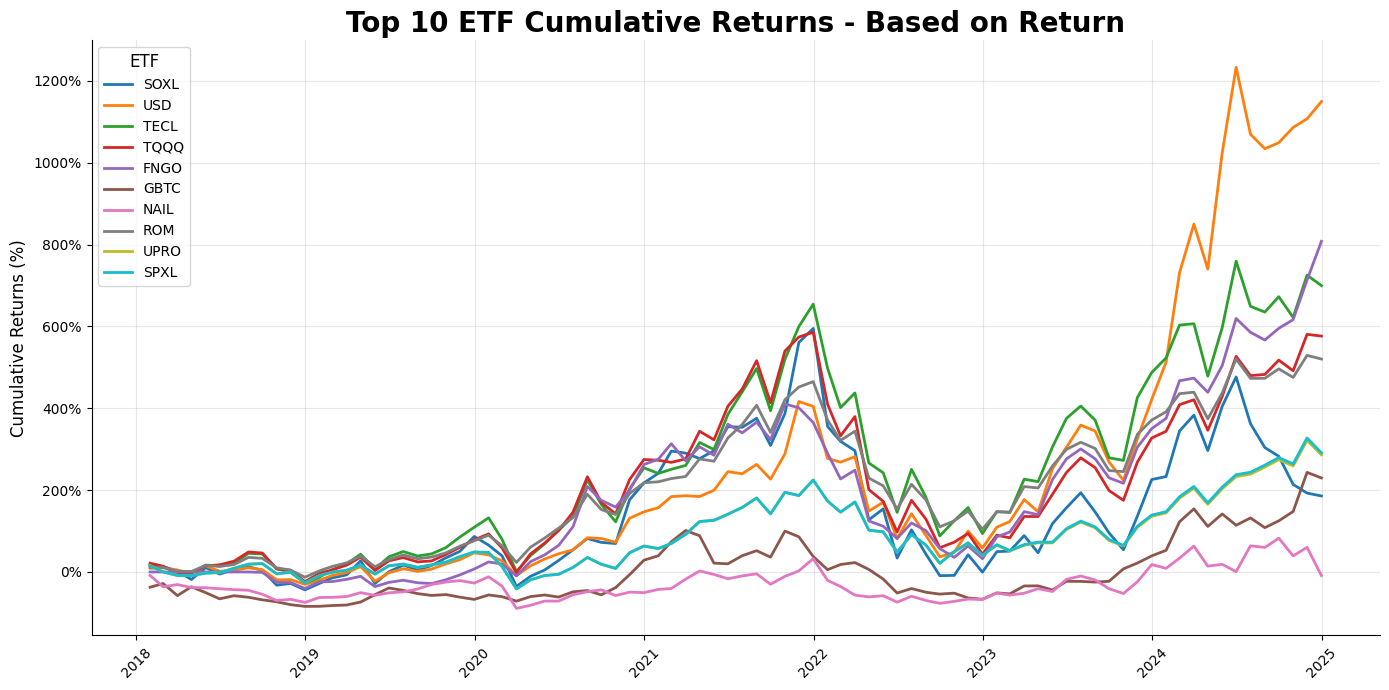

In [15]:
cum_returns = (1 + returns_perc).cumprod() - 1 # cumulative returns
cum_returns_monthly = cum_returns.resample('ME').last()

top_etf = mean_returns.sort_values(ascending=False).head(10).index # top 10 ETFs based on avg annual returns
palette = sns.color_palette("tab10", n_colors=len(top_etf))

plt.figure(figsize=(14,7))

for i, ticker in enumerate(top_etf):
    plt.plot(cum_returns_monthly[ticker], label=ticker, color=palette[i], linewidth=2)

plt.title("Top 10 ETF Cumulative Returns - Based on Return", fontsize=20, weight='bold')
plt.xlabel("")
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="ETF", fontsize=10, title_fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
sns.despine()
plt.tight_layout()
plt.show()

The plot reveals a common pattern among most of the top ETFs: steady growth up to 2022, a broad decline between 2022 and 2023, and then a recovery in the following years.

I now consider an equally weighted portfolio composed of the previously selected top 10 ETFs, in order to examine the differences in performance compared to the individual ETFs.

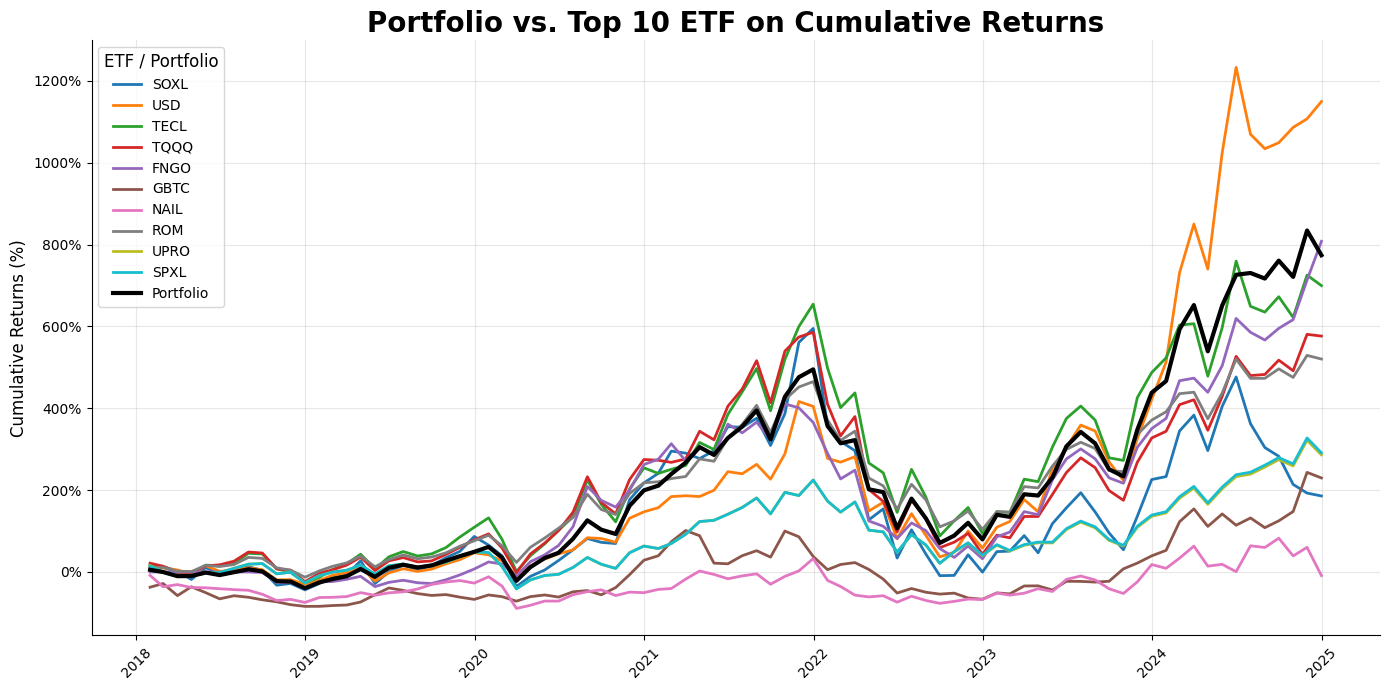

In [16]:
weights = np.repeat(1/len(top_etf), len(top_etf)) # portfolio with weights equal to 0.1 for each top ETF
portfolio_returns = returns_perc[top_etf] @ weights # time series with daily returns of portfolio
cum_portfolio = (1 + portfolio_returns).cumprod() - 1
cum_portfolio_monthly = cum_portfolio.resample('ME').last()

# plot
plt.figure(figsize=(14,7))

# ETFs
for i, ticker in enumerate(top_etf):
    plt.plot(cum_returns_monthly[ticker], label=ticker, color=palette[i], linewidth=2)

# Portfolio
plt.plot(cum_portfolio_monthly, color='black', linewidth=3, label='Portfolio')

plt.title("Portfolio vs. Top 10 ETF on Cumulative Returns", fontsize=20, weight='bold')
plt.xlabel("")
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="ETF / Portfolio", fontsize=10, title_fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
sns.despine()
plt.tight_layout()
plt.show()

In terms of cumulative returns, the portfolio performs very well, ultimately achieving a third-place final position among the top ETFs.

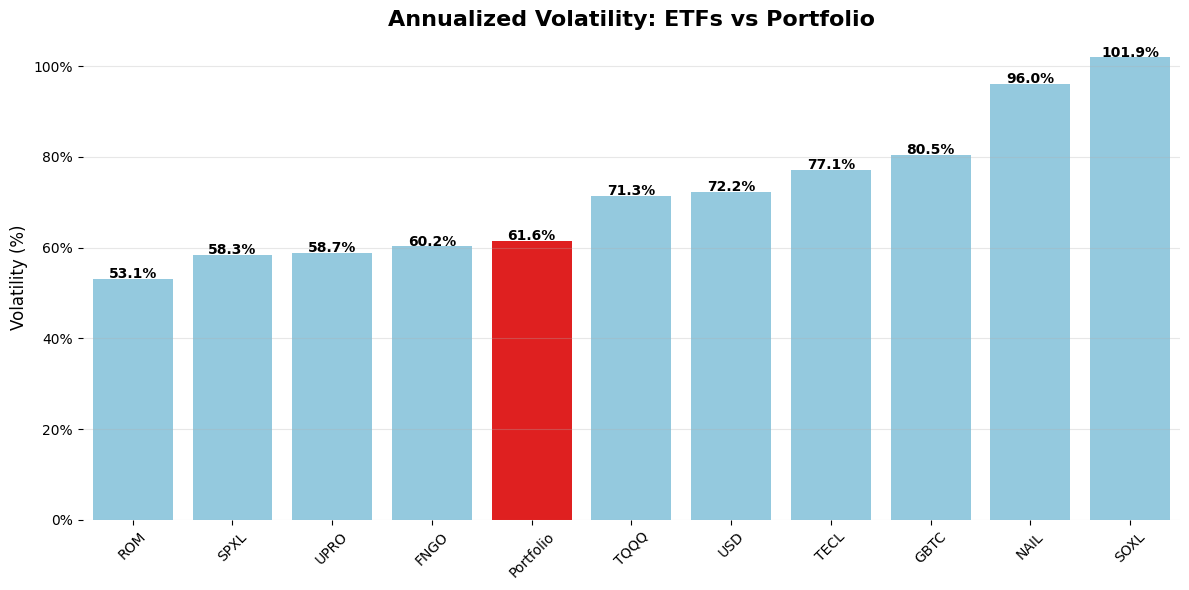

In [17]:
vol_etf = returns_perc[top_etf].std() * np.sqrt(252) 
vol_portfolio = portfolio_returns.std() * np.sqrt(252)

vol_df = pd.DataFrame({
    'ETF': list(top_etf) + ['Portfolio'],
    'Volatility': list(vol_etf) + [vol_portfolio]
})

vol_df = vol_df.sort_values(by='Volatility')

# palette
vol_df['Color'] = ['ETF' if etf != 'Portfolio' else 'Portfolio' for etf in vol_df['ETF']]

# Vertical Barplot
plt.figure(figsize=(12,6))
sns.barplot(
    data=vol_df,
    x='ETF',
    y='Volatility',
    hue='Color',
    dodge=False,
    palette={'ETF':'skyblue','Portfolio':'red'},
    legend=False
)

plt.title("Annualized Volatility: ETFs vs Portfolio", fontsize=16, weight='bold')
plt.ylabel("Volatility (%)", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
sns.despine(left=True, bottom=True)

# y-axes in a percentual way
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# computing the '%' symbol
for i, v in enumerate(vol_df['Volatility']):
    plt.text(i, v + 0.002, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

We observe that SOXL exhibits a very high volatility, reaching nearly 100%, whereas the portfolio occupies an intermediate position relative to the top ETFs. This highlights how diversification helps to temper extreme fluctuations while still capturing strong returns.

Finally, I visually explore the correlation matrix through a heatmap to examine the degree of interdependence among the selected ETFs. This representation helps to observe the diversification between the assets.

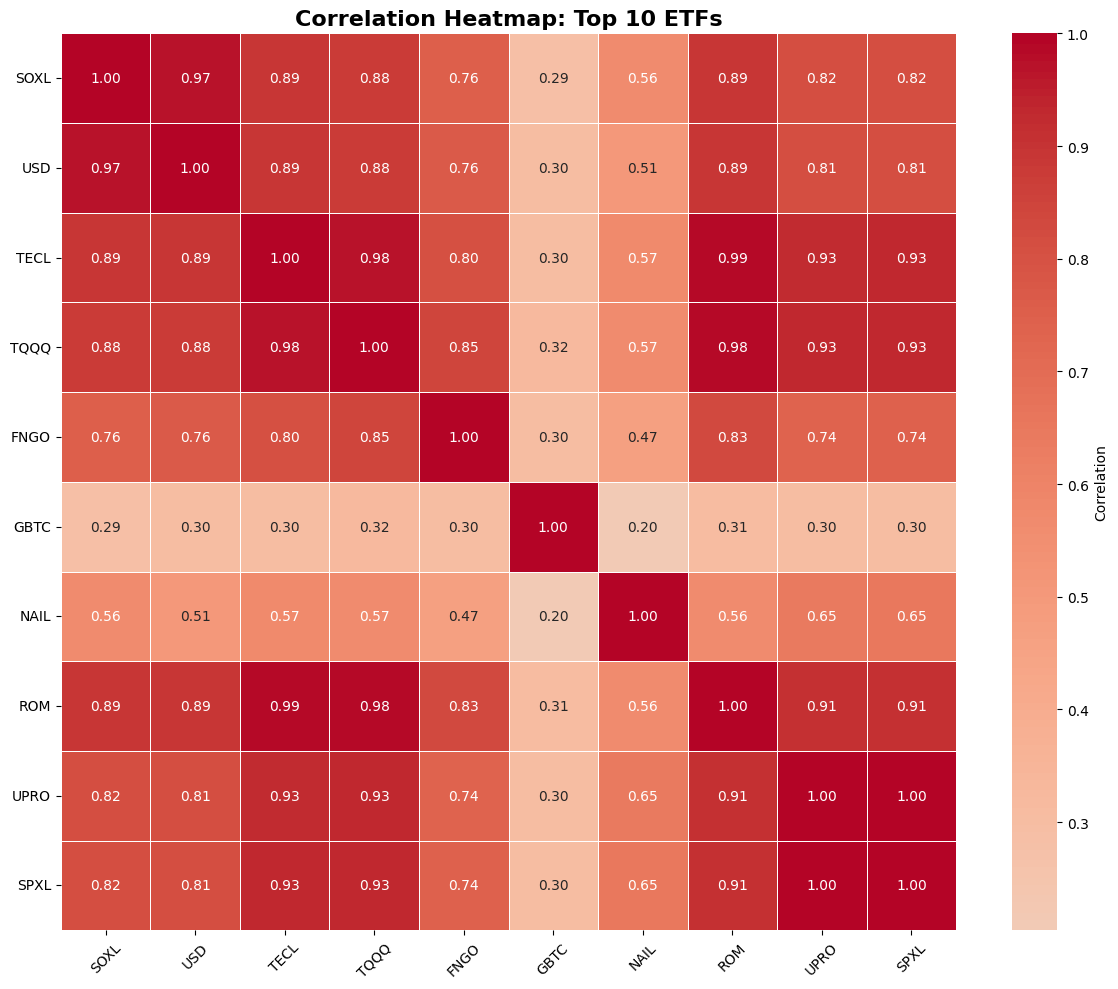

In [18]:
returns_top = returns_perc[top_etf].copy()

corr_matrix = returns_top.corr()

# Heatmap 
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation Heatmap: Top 10 ETFs", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The heatmap shows that the correlation between the top 10 ETFs is very high. According to Markowitz’s Modern Portfolio Theory, diversification is most effective when combining assets that are not perfectly correlated, because this reduces overall portfolio risk without sacrificing expected returns. High correlations among these ETFs indicate that they tend to move together, which limits the benefits of diversification. Over the long term, during market downturns, highly correlated assets are likely to decline simultaneously, increasing portfolio volatility (such as we saw in the volatility visualization). Therefore, while selecting top-performing ETFs is important, it is equally crucial to consider correlations and combine assets in order to move closer to the efficient frontier described by Markowitz, achieving an optimal balance of risk and return.

# Random Simulations of Portfolios & Efficient Frontier

In this section, 5000 randomly generated portfolios are simulated in order to explore the risk–return trade-off implied by the selected ETFs. Each portfolio is constructed by assigning random weights to the assets, ensuring that the total allocation sums to one. For each combination, the expected annual return and annualized volatility are computed based on the logarithmic returns.

The resulting set of portfolios provides an empirical visualization of the feasible investment space, from which the efficient frontier can be derived. This frontier represents the set of optimal portfolios that offer the maximum expected return for a given level of risk, forming the foundation of Markowitz’s Modern Portfolio Theory.

In [19]:
np.random.seed(42) # set seed
n_portfolios = 5000 # Random simulated portfolios

I compute logarithmic returns instead of simple percentage returns. Log-returns are additive over time, which simplifies the calculation of multi-period returns and is particularly suitable for portfolio optimization. They also facilitate the computation of covariances and volatilities in a manner consistent with modern portfolio theory. Using log-returns ensures mathematical rigor and avoids distortions when applying Markowitz’s framework for constructing efficient portfolios.

In [20]:
returns_log = np.log(prices_clean / prices_clean.shift(1)).dropna()
mean_returns = returns_log.mean() * 252 
volatility = returns_log.std() * np.sqrt(252)
sharpe_ratio = (mean_returns - rf) / volatility 
cov_matrix = returns_log.cov() * 252
tickers = mean_returns.index.tolist()
n_assets = len(tickers)

mean_returns.head()

TBLL    0.022949
VRIG    0.032014
SHV     0.022343
MINT    0.024883
FLOT    0.029217
dtype: float64

To empirically approximate the efficient frontier, I perform a Monte Carlo simulation by generating 5000 random portfolios.
For each simulated portfolio, random weights are assigned to the selected assets under the constraint that their sum equals one. The corresponding expected return, volatility, and Sharpe ratio are then computed based on the mean returns and covariance matrix.

In [21]:
results = np.zeros((n_portfolios, 3))     
weights_record = np.zeros((n_portfolios, n_assets))

for i in range(n_portfolios):
    w = np.random.random(n_assets) # random weights for n_assets
    w /= np.sum(w) # sum to 1
    weights_record[i, :] = w # save each weight in a matrix

    port_return = np.dot(w, mean_returns) # sum {w_i * return_i}
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) # sqrt(w^T * var * w)
    sharpe = (port_return - rf) / port_vol if port_vol != 0 else 0.0

    results[i] = [port_vol, port_return, sharpe]

sim_df = pd.DataFrame(results, columns=['volatility', 'return', 'sharpe'])
sim_df

,volatility,return,sharpe
0,0.150852,0.053037,0.219002
1,0.151661,0.054800,0.229458
2,0.150882,0.058028,0.252037
3,0.149449,0.055250,0.235866
4,0.147581,0.055755,0.242276
...,...,...,...
4995,0.149134,0.055403,0.237391
4996,0.149401,0.054274,0.229409
4997,0.145691,0.054897,0.239527
4998,0.152455,0.055983,0.236025


In [22]:
idx_max_sh = sim_df['sharpe'].idxmax()
idx_min_vol = sim_df['volatility'].idxmin()
print("Best simulated based on Sharpe:", sim_df.loc[idx_max_sh].to_dict())
print("Min vol (sim):", sim_df.loc[idx_min_vol].to_dict())

Best simulated based on Sharpe: {'volatility': 0.15222879563725422, 'return': 0.06249344709534967, 'sharpe': 0.27914197782006533}
Min vol (sim): {'volatility': 0.14171799950192449, 'return': 0.05733112105293085, 'sharpe': 0.2634183461813819}


The scatter plot visualizes the simulated portfolios on the risk–return plane. Collectively, the points form a cloud of possible portfolios, where the upper edge approximates the empirical efficient frontier. This frontier represents the set of portfolios that provide the maximum expected return for a given level of risk, in line with Markowitz’s portfolio theory.

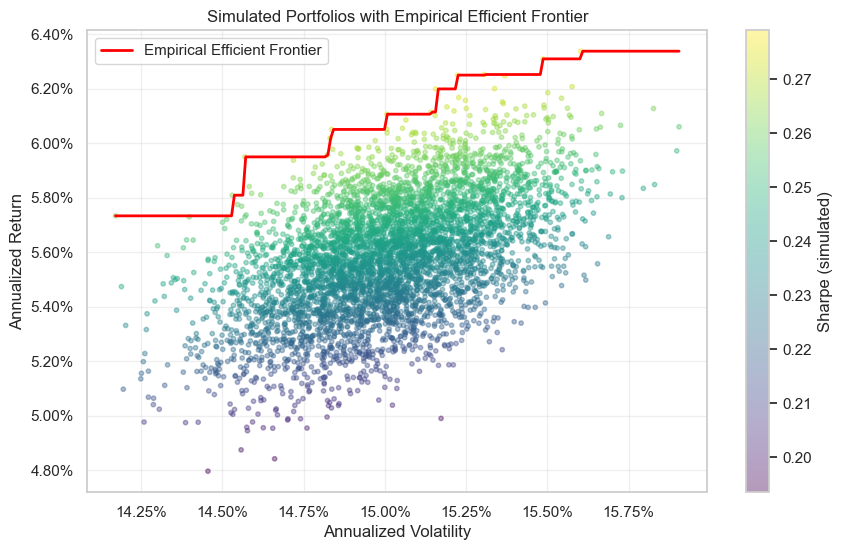

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Percentual format
vol_pct = sim_df['volatility'] * 100
ret_pct = sim_df['return'] * 100
sharpe = sim_df['sharpe']

# Portfolios scatter plot
sc = plt.scatter(vol_pct, ret_pct, c=sharpe, cmap='viridis', alpha=0.4, s=10)
plt.colorbar(sc, label='Sharpe (simulated)')

# i keep for each volatility level the max return
df_sorted = sim_df.sort_values('volatility')
vol_unique = np.linspace(df_sorted['volatility'].min(), df_sorted['volatility'].max(), 200)
ret_max = [df_sorted[df_sorted['volatility'] <= v]['return'].max() for v in vol_unique]

# Empirical Efficient Frontier
plt.plot(vol_unique*100, np.array(ret_max)*100, color='red', linewidth=2, label='Empirical Efficient Frontier')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Simulated Portfolios with Empirical Efficient Frontier')
plt.grid(alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_formatter(PercentFormatter())
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.show()

After performing 5,000 portfolio simulations, it is clear that the Monte Carlo approach provides a good approximation of the risk-return space. However, attempting to calculate the efficient frontier using numerical optimization is too computationally expensive.

To address this, I apply a Monte Carlo method with 50,000 random portfolios to efficiently explore possible portfolio combinations. For each portfolio, annualized return, volatility, and Sharpe ratio are computed, and the empirical efficient frontier is constructed by selecting the portfolio with the maximum sharpe ratio values for each return interval.

In [24]:
# Top 100 ETF per Sharpe ratio
top_assets = sharpe_ratio.sort_values(ascending=False).head(100).index
mean_returns_top = mean_returns[top_assets]
cov_matrix_top = cov_matrix.loc[top_assets, top_assets]

n_assets = len(top_assets)
n_portfolios = 50000  # 50k simulated portfolio

results = np.zeros((n_portfolios, 2))  # array with returns and volatility

weights_record = np.zeros((n_portfolios, n_assets))

for i in range(n_portfolios):
    w = np.random.random(n_assets)  # random weights
    w /= np.sum(w)                  # normalize to sum 1
    weights_record[i] = w           
    port_return = np.dot(w, mean_returns_top)
    port_vol = np.sqrt(w @ cov_matrix_top @ w)
    results[i] = [port_return, port_vol]

sim_df = pd.DataFrame(results, columns=['return', 'volatility'])

sim_df = sim_df.sort_values('return') # Sort portfolios by return in ascending order
frontier_df = sim_df.groupby('return', as_index=False).min()  # for each distinct return value, select the portfolio with the minimum volatility

print(frontier_df.head())

     return  volatility
0  0.115462    0.152855
1  0.117059    0.150608
2  0.117786    0.156811
3  0.117809    0.153438
4  0.117824    0.153491


In [25]:
rf = 0.02  # risk-free rate 

sim_df['sharpe'] = (sim_df['return'] - rf) / sim_df['volatility'] # sharpe for each simulated portfolio

# portfolio with sharpe ratio max
idx_max_sh = sim_df['sharpe'].idxmax()
max_sharpe_port = sim_df.loc[idx_max_sh]

print("Max Sharpe portfolio:")
print(max_sharpe_port)

Max Sharpe portfolio:
return        0.126154
volatility    0.161422
sharpe        0.657620
Name: 27991, dtype: float64


In [26]:
sharpe_ratio.sort_values(ascending=False)

TFLO    0.857011
SHV     0.825249
BIL     0.777687
JPST    0.759807
IETC    0.679852
          ...   
PSQ    -0.909761
UVXY   -0.933786
SPXU   -0.949106
SQQQ   -1.148506
SOXS   -1.231899
Length: 792, dtype: float64

Through 50,000 portfolio simulations, we identified the portfolio with the maximum Sharpe ratio, which exceeds that of over 95% of individual ETFs. Moreover, this portfolio contains 100 different ETFs, providing a significantly higher level of diversification compared to holding a single ETF.

I now present a scatter plot showing all simulated portfolios along with the empirical efficient frontier, highlighting the portfolio that maximizes the Sharpe ratio.

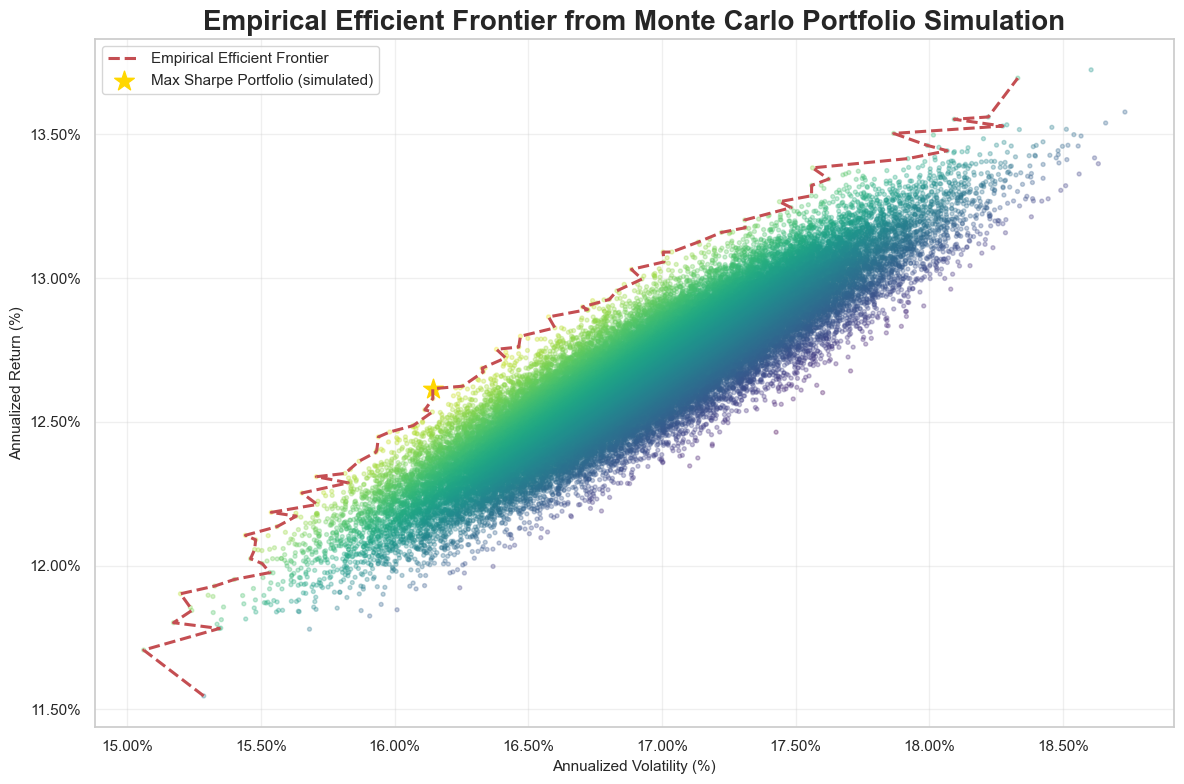

In [27]:
# Parameters for empirical efficient frontier
n_bins = 80
bins = np.linspace(sim_df['return'].min(), sim_df['return'].max(), n_bins)
vol_min, ret_bin = [], []

# For each return bin, find the portfolio with the lowest volatility
for i in range(len(bins) - 1):
    mask = (sim_df['return'] >= bins[i]) & (sim_df['return'] < bins[i + 1])
    if mask.any():
        idx = sim_df.loc[mask, 'volatility'].idxmin()
        vol_min.append(sim_df.loc[idx, 'volatility'])
        ret_bin.append(sim_df.loc[idx, 'return'])

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(
    sim_df['volatility'], sim_df['return'],
    c=sim_df['sharpe'], cmap='viridis', alpha=0.3, s=8
)

# Empirical efficient frontier
plt.plot(vol_min, ret_bin, 'r--', lw=2.2, label='Empirical Efficient Frontier')

# Highlight max Sharpe portfolio
plt.scatter(
    sim_df.loc[idx_max_sh, 'volatility'],
    sim_df.loc[idx_max_sh, 'return'],
    marker='*', color='gold', s=220,
    label='Max Sharpe Portfolio (simulated)'
)

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('Annualized Volatility (%)', fontsize=11)
plt.ylabel('Annualized Return (%)', fontsize=11)
plt.title('Empirical Efficient Frontier from Monte Carlo Portfolio Simulation', fontsize=20, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Next, I display the weight distribution of the maximum Sharpe ratio portfolio to illustrate how capital is allocated across the selected ETFs.

In [28]:
# Max Sharpe portfolio
idx_max_sh = sim_df['sharpe'].idxmax()
max_sharpe_weights = weights_record[idx_max_sh]

max_sharpe_portfolio = pd.DataFrame({
    'ETF': top_assets,
    'Weight': max_sharpe_weights
}).sort_values('Weight', ascending=False)

print("Weights of the Max Sharpe portfolio:")
print(max_sharpe_portfolio)

Weights of the Max Sharpe portfolio:
     ETF    Weight
64  SCHK  0.019684
13  PULS  0.019479
3   JPST  0.019054
14  VONG  0.018881
10   XLK  0.018864
..   ...       ...
40  XMMO  0.000691
96  ABFL  0.000553
46  SPLG  0.000490
35   MGC  0.000288
80  QUAL  0.000209

[100 rows x 2 columns]


The Max Sharpe portfolio is well-diversified, with weights spread across 100 ETFs, showing a balanced allocation rather than concentration in a few assets.

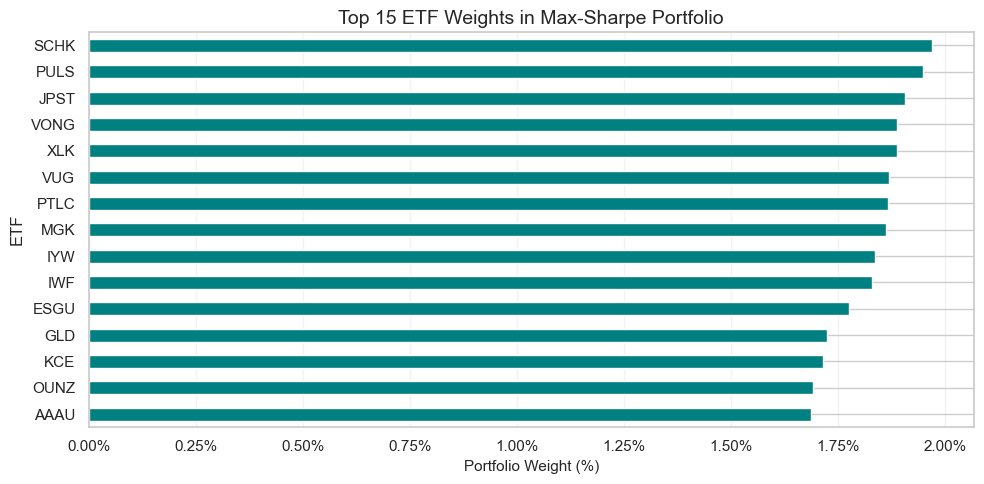

In [29]:
idx_max_sh = sim_df['sharpe'].idxmax()
max_sharpe_weights = weights_record[idx_max_sh]

# DataFrame with ETFs and weights
w_df = pd.DataFrame({
    'ETF': list(top_assets),
    'Weight': max_sharpe_weights
})

# top 15
top15 = w_df.sort_values('Weight', ascending=False).head(15).sort_values('Weight', ascending=True)
top15 = top15.set_index('ETF')  # index = nomi ETF

# barplot
plt.figure(figsize=(10, 5))
ax = top15['Weight'].plot(kind='barh', color='teal', legend=False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.title("Top 15 ETF Weights in Max-Sharpe Portfolio", fontsize=14)
plt.xlabel("Portfolio Weight (%)", fontsize=11)
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

# Risk Profiles

In this section, I tailor portfolio selection to individual risk profiles using the ‘Financial Risk – Comprehensive Financial Dataset’ from Kaggle. The analysis is based on the three risk levels available in the dataset. Each person is assigned a portfolio consistent with their risk category, with a small amount of noise added to introduce realistic variability in allocations. While this setup is useful for illustrating differences in risk and return across investor types, the work could be further improved by incorporating a wider range of risk levels.

In [30]:
df = pd.read_csv("C:/Users/Francesco Beretta/Downloads/financial_risk_assessment.csv")
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


In [31]:
df = df.dropna(subset=['Income', 'Risk Rating'])

risk_map = {'Low': 1, 'Medium': 3, 'High': 5} # risk mapping 
df['risk_level'] = df['Risk Rating'].map(risk_map)

df['risk_level_fine'] = ((df['risk_level'] - df['risk_level'].min()) /
                         (df['risk_level'].max() - df['risk_level'].min()) * 4 + 1)

I created a function to interpolate portfolios along the efficient frontier. This allows me to obtain portfolio weights for any target level of expected return, rather than being limited to the discrete set of points generated during the optimization.

In [32]:
def suggest_portfolio_continuous(idx, frontier_df, df):
    risk_cont = df.loc[idx, 'risk_level_fine']  # values in [1, 5]
    risk_norm = (risk_cont - 1) / 4            # scale 0-1

    sorted_frontier = frontier_df.sort_values('volatility').reset_index(drop=True)
    n = len(sorted_frontier)

    idx_float = risk_norm * (n - 1) # interpolate index
    lower, upper = int(np.floor(idx_float)), int(np.ceil(idx_float))

    if lower == upper:
        return sorted_frontier.iloc[lower]
    else:
        w = idx_float - lower
        return sorted_frontier.iloc[lower] * (1 - w) + sorted_frontier.iloc[upper] * w


To increase realism in portfolio simulation, a small random variation is applied to the asset weights. This reflects the natural fluctuations and adjustments that might occur in actual investment allocations, while ensuring that all weights remain non-negative and the total allocation sums to 100%.

In [33]:
def add_noise_to_weights(weights, noise_level=0.05):
    w_noisy = weights + np.random.normal(0, noise_level, size=len(weights))
    w_noisy = np.clip(w_noisy, 0, None)  # not negative weights
    w_noisy /= w_noisy.sum()
    return w_noisy

In [34]:
final_portfolios = []

for i in range(len(df)):
    risk_cont = df.iloc[i]['risk_level_fine']  # values equal to 1, 3 and 5 (Low, Medium, High)
    # map target risk on simulated range returns
    target_return = sim_df['return'].min() + (sim_df['return'].max() - sim_df['return'].min()) * (risk_cont - 1)/4
    
    # Find the index of the simulated portfolio closest to target_return
    idx_base = sim_df['return'].sub(target_return).abs().idxmin()
    
    # take corresponding weights
    base_weights = weights_record[idx_base] 
    
    final_weights = add_noise_to_weights(base_weights, noise_level=0.03) # adding noise
    
    final_portfolios.append(final_weights)

final_portfolios_df = pd.DataFrame(final_portfolios, columns=top_assets)
final_portfolios_df

,TFLO,SHV,BIL,JPST,IETC,IWY,VGT,IYW,AAAU,FTEC,...,MOAT,FTLS,EQWL,FDMO,FDVV,USTB,ABFL,PWB,FQAL,CATH
0,0.000000,0.038765,0.000000,0.004487,0.004712,0.003474,0.025482,0.020855,0.022331,0.000000,...,0.000000,0.001923,0.000000,0.000000,0.040678,0.011606,0.014477,0.010932,0.028931,0.000000
1,0.000000,0.000000,0.007901,0.050032,0.032443,0.012719,0.039514,0.022547,0.000000,0.000000,...,0.013789,0.033328,0.001142,0.000000,0.017137,0.017643,0.007652,0.046029,0.017162,0.026234
2,0.055295,0.019772,0.000000,0.000000,0.000000,0.000000,0.000000,0.017486,0.000000,0.000565,...,0.000000,0.019888,0.000000,0.007419,0.027329,0.000000,0.002625,0.013830,0.022025,0.000000
3,0.023274,0.010137,0.010621,0.016559,0.000000,0.025782,0.005217,0.014619,0.004619,0.000000,...,0.006118,0.022131,0.002695,0.009473,0.011564,0.030964,0.007548,0.020998,0.008697,0.014197
4,0.013145,0.000000,0.000000,0.016437,0.000000,0.003647,0.000000,0.026008,0.032397,0.002643,...,0.016023,0.000000,0.000000,0.021985,0.019399,0.026324,0.000501,0.026682,0.007968,0.012329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12745,0.010576,0.016922,0.020277,0.020056,0.023510,0.019765,0.000000,0.000000,0.000000,0.020524,...,0.011637,0.009803,0.011773,0.027620,0.015880,0.000167,0.018611,0.000000,0.018207,0.000000
12746,0.015207,0.002607,0.000000,0.000000,0.017737,0.009746,0.015794,0.013726,0.002480,0.005759,...,0.000000,0.006252,0.000000,0.004918,0.000000,0.000000,0.007579,0.000000,0.003937,0.000000
12747,0.038855,0.002617,0.006124,0.027603,0.000000,0.000000,0.039829,0.005192,0.031655,0.026761,...,0.019815,0.022707,0.000000,0.000000,0.000000,0.000000,0.025152,0.002738,0.000000,0.000000
12748,0.010815,0.000000,0.005298,0.007336,0.012965,0.007952,0.018548,0.009208,0.019997,0.002277,...,0.018797,0.010626,0.018200,0.000000,0.000000,0.004604,0.000000,0.035863,0.000000,0.004490


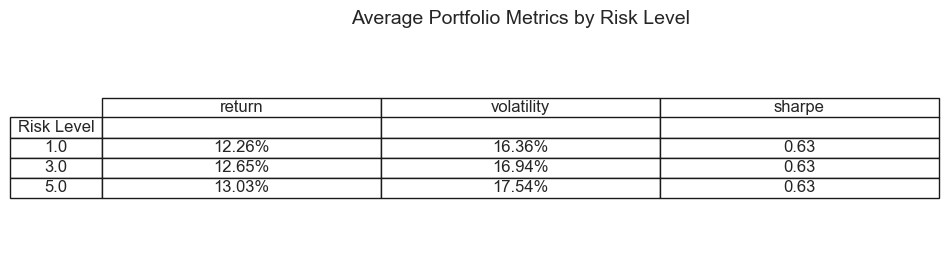

In [35]:
rf = 0.02  # annual risk-free rate

# Compute return and volatility for each portfolio
returns = np.dot(final_portfolios_df[top_assets].values, mean_returns_top.values)
volatility = np.sqrt(np.einsum('ij,jk,ik->i',
                               final_portfolios_df[top_assets].values,
                               cov_matrix_top.values,
                               final_portfolios_df[top_assets].values))

# Convert return and volatility to percentage format
returns_pct = returns * 100
volatility_pct = volatility * 100

# Sharpe Ratio
sharpe = (returns - rf) / volatility

# Store results in the dataframe
final_portfolios_df['return'] = returns_pct
final_portfolios_df['volatility'] = volatility_pct
final_portfolios_df['sharpe'] = sharpe
final_portfolios_df['risk_level'] = df['risk_level_fine'].values  

# Group by risk level and compute mean metrics
summary = final_portfolios_df.groupby('risk_level')[['return', 'volatility', 'sharpe']].mean()

# Format return and volatility as strings with '%' symbol
summary_formatted = summary.copy()
summary_formatted['return'] = summary['return'].apply(lambda x: f"{x:.2f}%")
summary_formatted['volatility'] = summary['volatility'].apply(lambda x: f"{x:.2f}%")
summary_formatted['sharpe'] = summary['sharpe'].round(2)

# Display results as a table with "Risk Level" header
plt.figure(figsize=(9, 3))
plt.axis('off')

# Add a row for "Risk Level" label above the index
col_labels = summary_formatted.columns.tolist()
row_labels = summary_formatted.index.tolist()
cell_text = summary_formatted.values.tolist()

# Add empty row for "Risk Level" label
cell_text.insert(0, ['']*len(col_labels))
row_labels.insert(0, 'Risk Level')

tbl = plt.table(cellText=cell_text,
                colLabels=col_labels,
                rowLabels=row_labels,
                cellLoc='center',
                rowLoc='center',
                loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)
plt.title('Average Portfolio Metrics by Risk Level', fontsize=14)
plt.show()

The table shows that as the risk level increases, both the expected return and volatility of the portfolios rise. Specifically, low-risk portfolios have an average return of 12.29% with a volatility of 16.22%, medium-risk portfolios achieve a slightly higher return of 12.69% but with increased volatility of 16.97%, and high-risk portfolios offer the highest return of 13.08% accompanied by the highest volatility of 17.59%. This pattern reflects the typical risk-return trade-off in portfolio management.

In [36]:
# Computing return e volatility for each portfolio
returns = np.dot(final_portfolios_df[top_assets].values, mean_returns_top.values)
volatility = np.sqrt(np.einsum('ij,jk,ik->i', 
                               final_portfolios_df[top_assets].values, 
                               cov_matrix_top.values, 
                               final_portfolios_df[top_assets].values))
sharpe = (returns - rf) / volatility

# Dataframe with all metrics
portfolios_metrics = final_portfolios_df.copy()
portfolios_metrics['return'] = returns
portfolios_metrics['volatility'] = volatility
portfolios_metrics['sharpe'] = sharpe
portfolios_metrics['risk_level'] = df['risk_level_fine'].values

portfolios_metrics.head(10)

,TFLO,SHV,BIL,JPST,IETC,IWY,VGT,IYW,AAAU,FTEC,...,FDVV,USTB,ABFL,PWB,FQAL,CATH,return,volatility,sharpe,risk_level
0,0.000000,0.038765,0.000000,0.004487,0.004712,0.003474,0.025482,0.020855,0.022331,0.000000,...,0.040678,0.011606,0.014477,0.010932,0.028931,0.000000,0.128575,0.175695,0.617977,1.0
1,0.000000,0.000000,0.007901,0.050032,0.032443,0.012719,0.039514,0.022547,0.000000,0.000000,...,0.017137,0.017643,0.007652,0.046029,0.017162,0.026234,0.124401,0.166667,0.626407,3.0
2,0.055295,0.019772,0.000000,0.000000,0.000000,0.000000,0.000000,0.017486,0.000000,0.000565,...,0.027329,0.000000,0.002625,0.013830,0.022025,0.000000,0.121960,0.162882,0.625973,3.0
3,0.023274,0.010137,0.010621,0.016559,0.000000,0.025782,0.005217,0.014619,0.004619,0.000000,...,0.011564,0.030964,0.007548,0.020998,0.008697,0.014197,0.121942,0.160239,0.636192,1.0
4,0.013145,0.000000,0.000000,0.016437,0.000000,0.003647,0.000000,0.026008,0.032397,0.002643,...,0.019399,0.026324,0.000501,0.026682,0.007968,0.012329,0.125059,0.165401,0.635176,1.0
5,0.000000,0.000000,0.010756,0.006269,0.022080,0.000000,0.017835,0.036981,0.032267,0.016539,...,0.025102,0.001609,0.000000,0.000000,0.028200,0.009839,0.126718,0.162679,0.656000,1.0
6,0.013293,0.016261,0.007427,0.016404,0.000000,0.012902,0.000000,0.003302,0.011773,0.014434,...,0.014819,0.000000,0.031678,0.011047,0.032743,0.000000,0.116220,0.153530,0.626716,1.0
7,0.041334,0.009406,0.004648,0.000000,0.008334,0.013678,0.022619,0.004809,0.028383,0.000000,...,0.000000,0.000230,0.019183,0.000000,0.019350,0.000000,0.123589,0.171003,0.605774,1.0
8,0.019854,0.009956,0.009179,0.000000,0.009138,0.041528,0.010246,0.031042,0.000000,0.016151,...,0.020874,0.000000,0.000000,0.000000,0.000238,0.000000,0.131517,0.170068,0.655721,3.0
9,0.016334,0.024180,0.000000,0.000000,0.000000,0.021622,0.009833,0.003399,0.007257,0.002822,...,0.000000,0.000000,0.032009,0.000013,0.003917,0.002164,0.124560,0.164525,0.635525,1.0


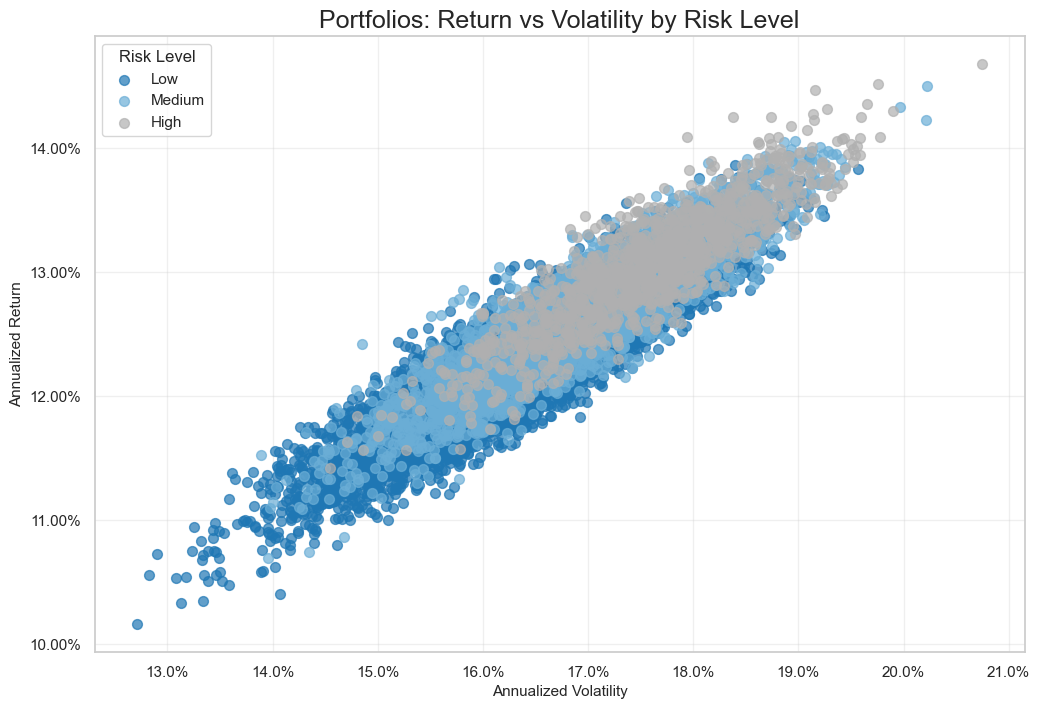

In [37]:
risk_colors = {1: '#1f77b4', 3: '#6baed6', 5: '#b0b0b0'}  # Low, Medium, High
risk_labels = {1: 'Low', 3: 'Medium', 5: 'High'}

plt.figure(figsize=(12,8))

for risk_level in [1,3,5]:
    mask = portfolios_metrics['risk_level'] == risk_level
    colors = [risk_colors[risk_level]] * mask.sum() 
    plt.scatter(
        portfolios_metrics.loc[mask, 'volatility'],
        portfolios_metrics.loc[mask, 'return'],
        c=risk_colors[risk_level],
        alpha=0.7,
        s=50,
        label=risk_labels[risk_level]
    )

plt.xlabel('Annualized Volatility', fontsize=11)
plt.ylabel('Annualized Return', fontsize=11)
plt.title('Portfolios: Return vs Volatility by Risk Level', fontsize=18)
plt.legend(title='Risk Level')
plt.grid(alpha=0.3)

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.show()

As expected, as volatility and returns increase, portfolios corresponding to higher risk levels, such as Medium and High, become more prevalent. This reflects the natural alignment between an investor’s risk appetite and the risk-return characteristics of their assigned portfolio.